In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
class Emprunteur_agent():

    def __init__(self, taux, montant_restant, duree_restante, proba_default, date_emprunt, notation=None, a_fait_defaut=False):
        self.id = np.random.randint(0, 10000000)
        self.taux = taux
        self.montant_initial = montant_restant # montant initial emprunté
        self.montant_restant = montant_restant # montant restant dû
        self.mensualite = montant_restant * (taux / 12) / (1 - (1 + taux / 12) ** -duree_restante)
        self.duree_restante = duree_restante # durée restante
        self.duree_totale = duree_restante # durée totale
    
        self.proba_default = proba_default # probabilité de défaut
        self.date_emprunt = date_emprunt # date de l'emprunt (pour calculer la durée restante)

        self.a_fait_defaut = a_fait_defaut

        self.notation = notation # notation de l'emprunteur

    def __str__(self):
        if self.a_fait_defaut != True:
            return f"Emprunteur N°{self.id} a {self.montant_restant}€ restant à rembourser, avec une mensualité de {self.mensualite:.2f}€ et un taux de {self.taux * 100}%, (risque de défaut de {self.proba_default * 100}%)"
        else:
            return f"L'emprunteur N°{self.id} a fait défaut (montant restant : {self.montant_initial}€)"
    
    def remboursement_mensuel(self):
        self.montant_restant -= self.mensualite
        self.duree_restante -= 1

    def taux_effectif(self):
        s = 0
        for _ in range(self.duree_totale):
            s += self.mensualite
        return (s - self.montant_initial) / (self.montant_initial * self.duree_totale)


class Portfolio():
    def __init__(self, liste_emprunteurs, liquidite):
        self.liste_emprunteurs = liste_emprunteurs
        self.liquidite = -liquidite
        for e in self.liste_emprunteurs:
            self.liquidite -= e.montant_initial
    
    def mensualite_totale(self):
        cumul = 0
        for emprunteur in self.liste_emprunteurs:
            cumul += emprunteur.mensualite
        return cumul
    
    def montant_initial(self):
        cumul = 0
        for emprunteur in self.liste_emprunteurs:
            cumul += emprunteur.montant_initial
        return cumul

    def montant_total(self):
        cumul = 0
        for emprunteur in self.liste_emprunteurs:
            cumul += emprunteur.montant_restant
        return cumul
    
    def montant_remboursement_total(self, emprunteur):
        cumul = 0
        for _ in range(emprunteur.duree_restante):
            cumul += emprunteur.mensualite
            emprunteur.remboursement_mensuel()
        return cumul   
    
    def default(self, e):
        if np.random.rand() < e.proba_default:
            e.a_fait_defaut = True
            e.montant_restant = 0
            e.duree_restante = 0

    def amortissement_emprunteur(self, e):
        cumul = 0
        for _ in range(e.duree_restante):
            cumul += e.mensualite
            self.default(e)
            if e.a_fait_defaut:
                break
            else:
                self.liquidite += e.mensualite
                e.remboursement_mensuel()
        return cumul
        

class Strategy():

    def __init__(self, nb_emprunt, montant_a_investir, date_emprunt, taux, proba_defaut):
        self.nb_emprunt = nb_emprunt # nombre d'emprunts à investir 
        self.montant_a_investir = montant_a_investir # montant à investir
        self.date_emprunt = date_emprunt # date de l'emprunt
        self.amortissements = {} # dictionnaire des amortissements des emprunteurs
        self.portfolio = None # portefeuille d'emprunteurs 
        self.taux = taux # taux d'intérêt moyen
        self.proba_defaut = proba_defaut # probabilité de défaut moyenne

    def investissement(self):
        montant_par_emprunt = self.montant_a_investir / self.nb_emprunt
        liste_emprunteurs = []
        # for _ in range(self.nb_emprunt):
        #     taux = np.random.uniform(self.taux * 0.9,self.taux * 1.1)
        #     montant_restant = np.random.randint(montant_par_emprunt, montant_par_emprunt+1)
        #     duree_restante = np.random.randint(12, 36)
        #     defaut = round(np.random.uniform(self.proba_defaut * 0.9, 1.1 * self.proba_defaut), 2) / duree_restante
        #     liste_emprunteurs.append(Emprunteur_agent(taux, montant_restant, duree_restante, defaut, self.date_emprunt))
        #     self.montant_a_investir -= montant_restant
        # self.portfolio = Portfolio(liste_emprunteurs, self.montant_a_investir) 
        for _ in range(self.nb_emprunt):
            taux = self.taux
            montant_restant = montant_par_emprunt
            duree_restante = np.random.randint(12, 13)
            # defaut = self.proba_defaut / duree_restante
            defaut = self.proba_defaut / duree_restante
            liste_emprunteurs.append(Emprunteur_agent(taux, montant_restant, duree_restante, defaut, self.date_emprunt))
            self.montant_a_investir -= montant_restant
        self.portfolio = Portfolio(liste_emprunteurs, self.montant_a_investir) 

    def Liquidite(self):
        for e in self.portfolio.liste_emprunteurs:
            self.amortissements[e.id] = self.portfolio.amortissement_emprunteur(e)
        return self.portfolio.liquidite


class Backtest:

    def __init__(self, nb_emprunt, montant_a_investir, date_emprunt, taux, proba_defaut, nb_essais):
        self.nb_emprunt = nb_emprunt
        self.montant_a_investir = montant_a_investir
        self.date_emprunt = date_emprunt
        self.taux = taux
        self.proba_defaut = proba_defaut
        self.nb_essais = nb_essais

        self.final_liquidite = None
        self.results = None
        self.is_backtested = False
        self.is_results_calculated = False


    def backtest(self, pt_bin=0.01):
        self.results = {}

        final_liquidite = {}
        for n in self.nb_emprunt:
            self.results[n] = {}
            final_liquidite[n] = []
            for _ in range(self.nb_essais):
                s = Strategy(n, self.montant_a_investir, self.date_emprunt, self.taux, self.proba_defaut)
                s.investissement()
                final_liquidite[n].append(s.Liquidite())

        self.final_liquidite = pd.DataFrame(final_liquidite, columns=self.nb_emprunt, index=range(self.nb_essais))
        self.final_liquidite /= self.montant_a_investir # Normalize results by the amount invested to compare strategies with different amounts invested
        self.is_backtested = True

    def calculate_results(self):
        if not self.is_results_calculated:
            for n in self.nb_emprunt:

                self.results[n]['VaR 95%'] = self.final_liquidite[n].quantile(0.05)
                self.results[n]['ES 95%'] = self.final_liquidite[n][self.final_liquidite[n] < self.results[n]['VaR 95%']].mean()
                self.results[n]['VaR 99%'] = self.final_liquidite[n].quantile(0.01)
                self.results[n]['ES 99%'] = self.final_liquidite[n][self.final_liquidite[n] < self.results[n]['VaR 99%']].mean()
                self.results[n]['Mean'] = self.final_liquidite[n].mean()
                self.results[n]['Std'] = self.final_liquidite[n].std()
                self.results[n]['Max'] = self.final_liquidite[n].max()
                self.results[n]['Min'] = self.final_liquidite[n].min()
                self.results[n]['Median'] = self.final_liquidite[n].median()
                self.results[n]['Mode'] = self.final_liquidite[n].mode()

                self.results[n]['Expected Loss'] = self.final_liquidite[n][self.final_liquidite[n] < 0].mean()
                self.results[n]['Expected Gain'] = self.final_liquidite[n][self.final_liquidite[n] > 0].mean()
                self.results[n]['Lower Semi Deviation'] = self.final_liquidite[n][self.final_liquidite[n] < self.results[n]['Mean']].std()
                self.results[n]['Upper Semi Deviation'] = self.final_liquidite[n][self.final_liquidite[n] > self.results[n]['Mean']].std()

                self.results[n]['Sortino Ratio'] = self.results[n]['Mean'] / self.results[n]['Lower Semi Deviation']
                self.results[n]['Sharpe Ratio'] = self.results[n]['Mean'] / self.results[n]['Std']
                self.results[n]['Information Ratio'] = self.results[n]['Mean'] / self.results[n]['ES 95%']
                self.results[n]['Calmar Ratio'] = self.results[n]['Mean'] / self.final_liquidite[n].max()
                self.results[n]['Sterling Ratio'] = self.results[n]['Mean'] / self.results[n]['Lower Semi Deviation']
                self.results[n]['Skewness'] = self.final_liquidite[n].skew()
                self.results[n]['Kurtosis'] = self.final_liquidite[n].kurtosis()

                self.results[n] = pd.DataFrame(self.results[n], index=[n])
            # Combine all results into a single DataFrame
            self.results = pd.concat(self.results, axis=0).reset_index(drop=True).T
            self.results = self.results.round(3)
            self.results.columns = self.nb_emprunt
            self.is_results_calculated = True
        else:
            print("Results already calculated")

    def compute_mode(self):
        for n in self.nb_emprunt:
            self.results[n]['Mode'] = self.final_liquidite[n].mode()
            self.results[n]['Mode'] = self.results[n]['Mode'].apply(lambda x: x[0])
            self.results[n]['Mode'] = self.results[n]['Mode'].fillna(0)
            self.results[n]['Mode'] = self.results[n]['Mode'].astype(int)


    def plot_results(self):
        for n in self.nb_emprunt:
            plt.figure(figsize=(15, 5))
            sns.histplot(self.final_liquidite[n], kde=True, label=f"{n} emprunts", color=[np.random.rand(), np.random.rand(), np.random.rand()])
            plt.title("Distribution du gain final")
            plt.xlabel("Gain/Perte (€)")
            plt.ylabel("Nb d'occurences")
            plt.legend()
            plt.show()

In [3]:
# Set your parameters
nb_emprunt = [1]
montant_a_investir = 10000
date_emprunt = "2023-01-01"
proba_defaut = 0.06
nb_essais = 1000
pt_bin = 0.01

taux_liste = np.linspace(0.001, 0.4, 50)
defaut_liste = np.linspace(0.01, 0.1, 10)

d = {}
for defaut in tqdm(defaut_liste):
    t = {}
    for taux in tqdm(taux_liste):
        b = Backtest(nb_emprunt=nb_emprunt, 
                    montant_a_investir=montant_a_investir, 
                    date_emprunt=date_emprunt,
                    taux=taux,
                    proba_defaut=defaut,
                    nb_essais=nb_essais)

        b.backtest()
        b.calculate_results()
        b.final_liquidite
        binned = pd.DataFrame(pd.cut(b.final_liquidite[nb_emprunt[0]], bins=np.arange(-montant_a_investir, 1.25*montant_a_investir, pt_bin), labels=False, include_lowest=True) * pt_bin, columns=nb_emprunt)
        binned -= montant_a_investir
        
        t[taux] = binned.mode()[nb_emprunt[0]][0]
    d[defaut] = t


  0%|          | 0/10 [00:00<?, ?it/s]

: 

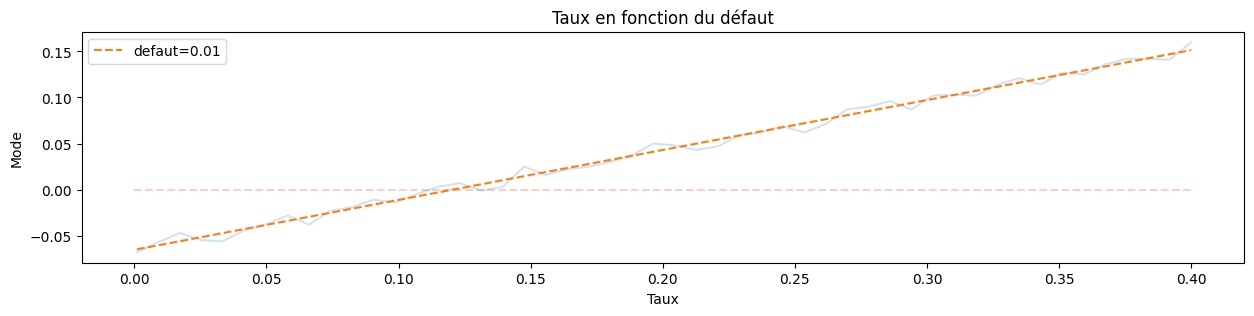

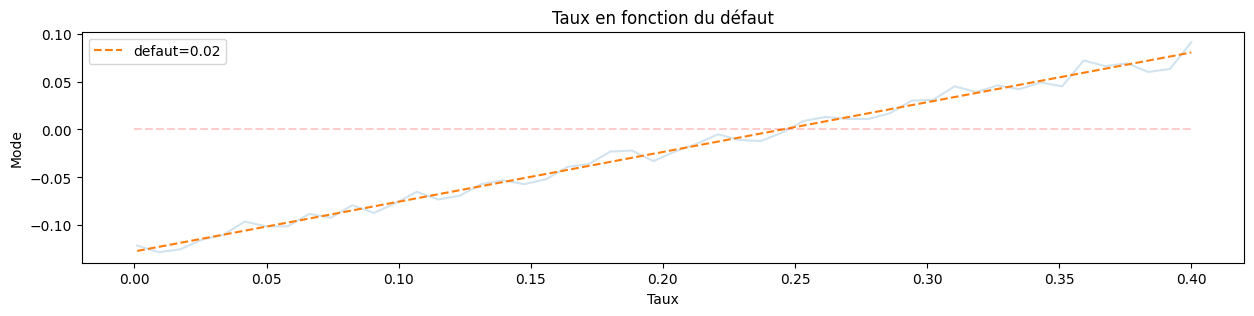

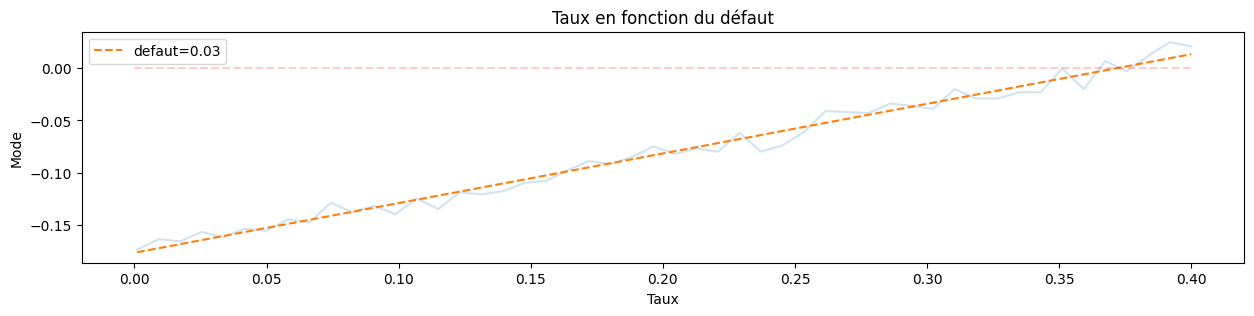

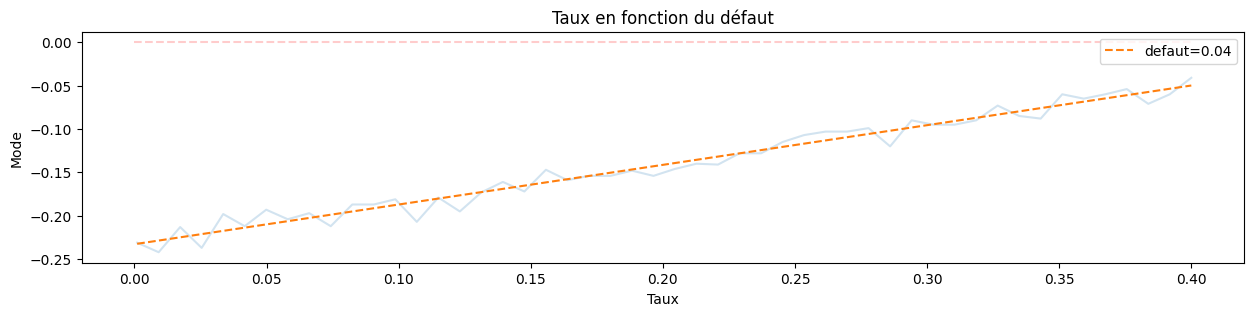

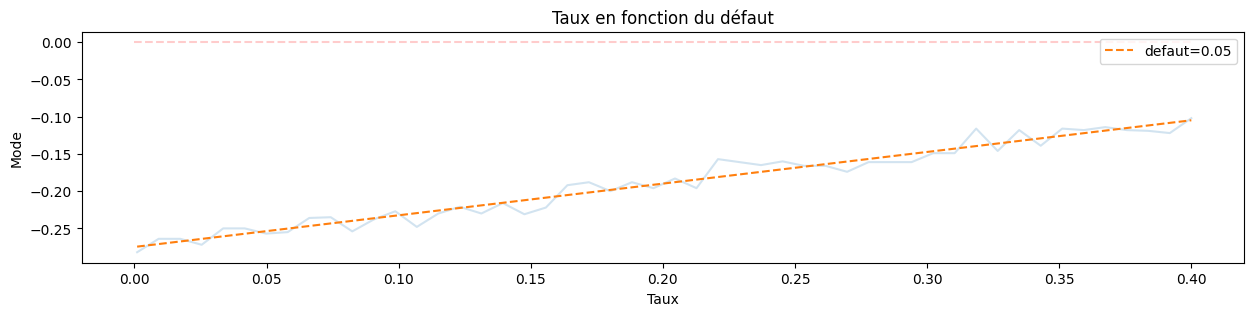

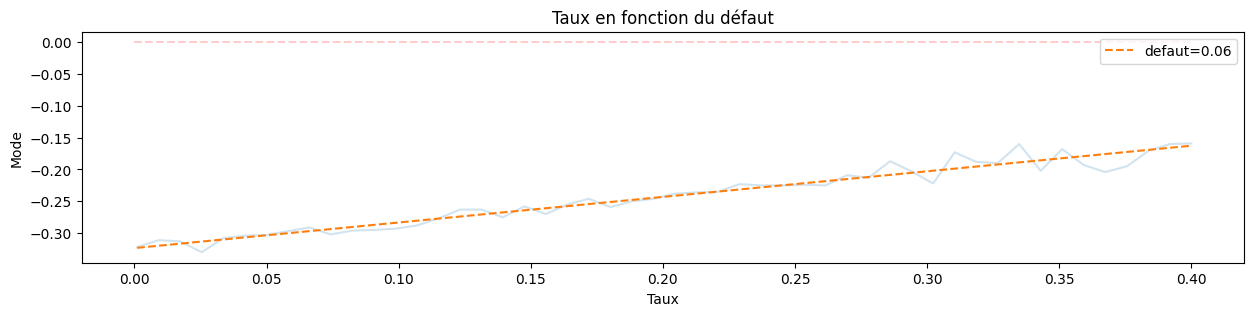

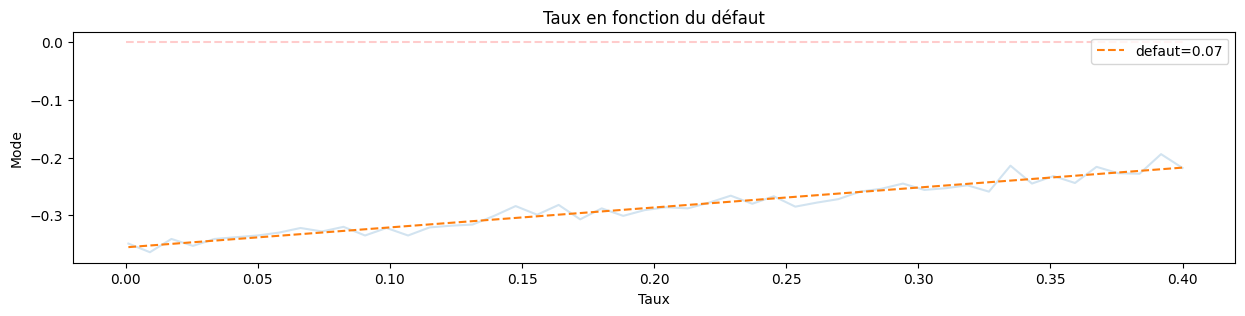

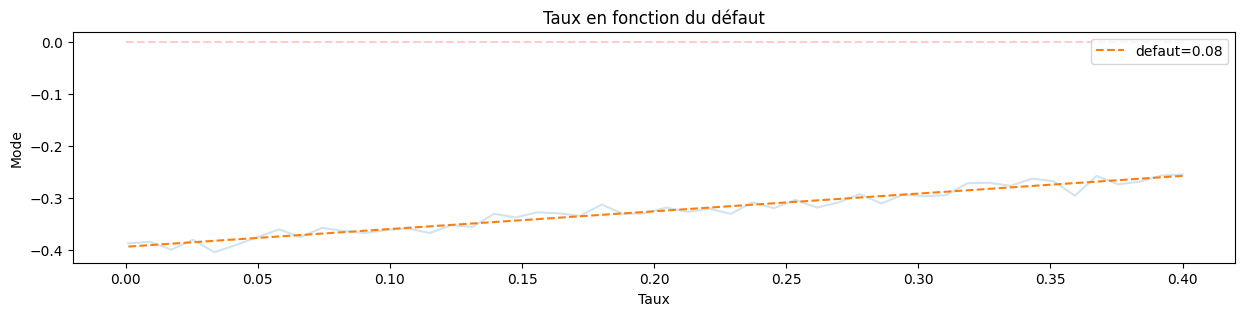

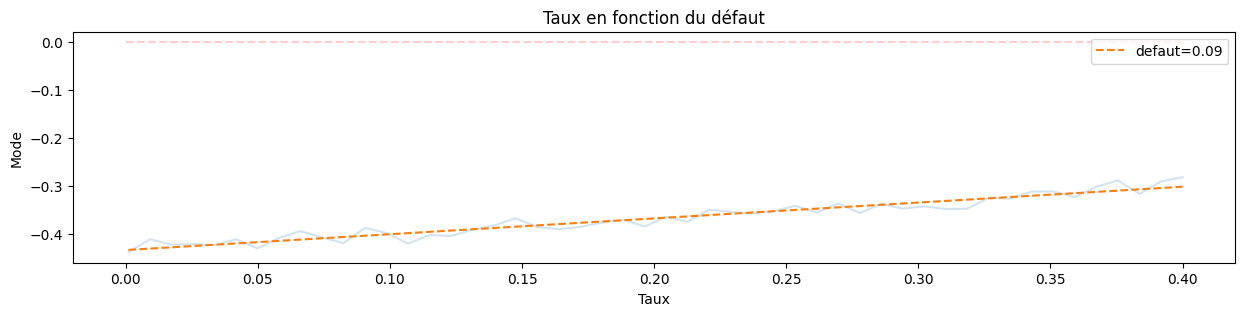

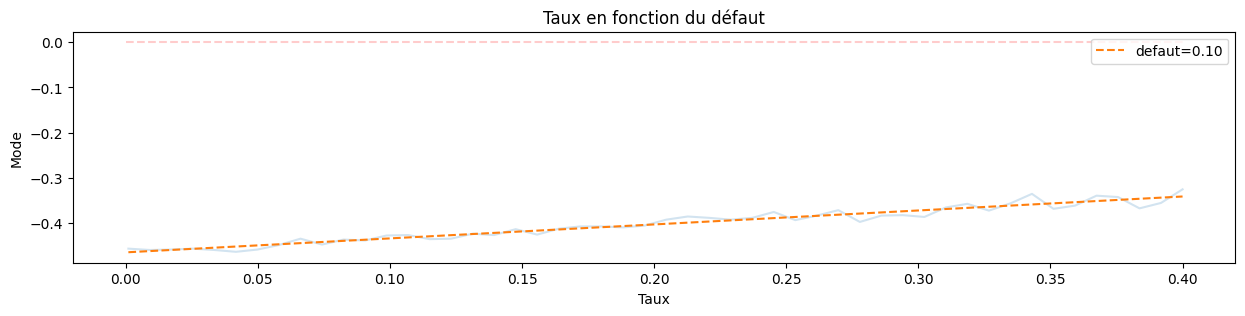

In [9]:
from scipy import stats


for defaut, t in d.items():
    plt.figure(figsize=(15, 3))
    plt.plot(t.keys(), t.values(), alpha=0.2)
    slope, intercept, r_value, p_value, std_err = stats.linregress(list(t.keys()), list(t.values()))
    plt.plot(t.keys(), slope * np.array(list(t.keys())) + intercept, '--', label=f"defaut={defaut:.2f}")
    plt.hlines(0, 0, 0.4, colors='r', linestyles='dashed', alpha=0.2)
    plt.legend()
    plt.title(f"Taux en fonction du défaut")
    plt.xlabel("Taux")
    plt.ylabel("Mode")
plt.show()


In [22]:
b = Backtest(nb_emprunt=[1, 10, 30, 40, 80],
                montant_a_investir=1000,
                date_emprunt="2021-01-01",
                taux=0.1,
                proba_defaut=0.06,
                nb_essais=10000)

b.backtest()
b.calculate_results()


<Axes: title={'center': 'Mode de la distribution du gain final'}>

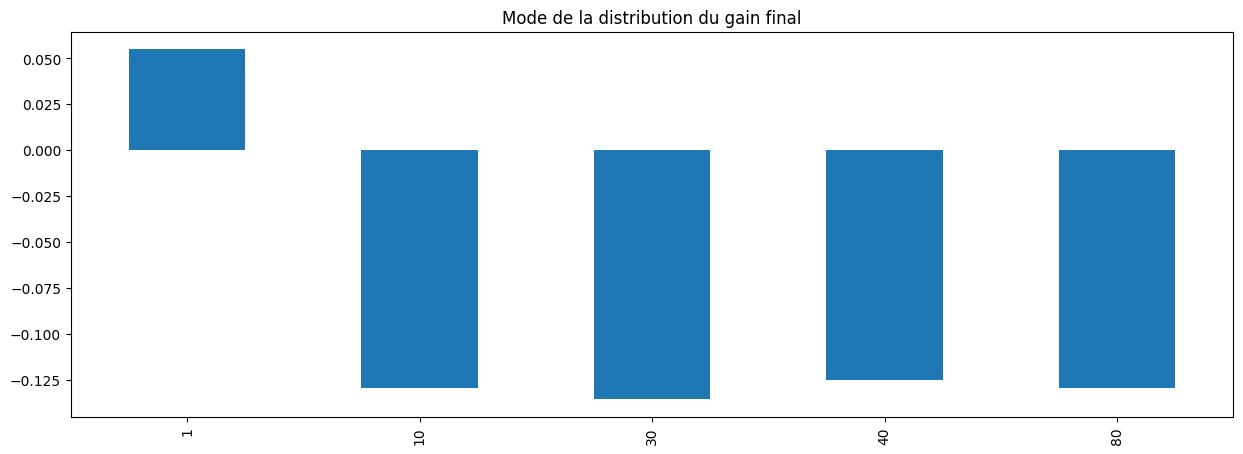

In [23]:
b.final_liquidite.mode().mean().plot(kind='bar', figsize=(15, 5), title="Mode de la distribution du gain final")

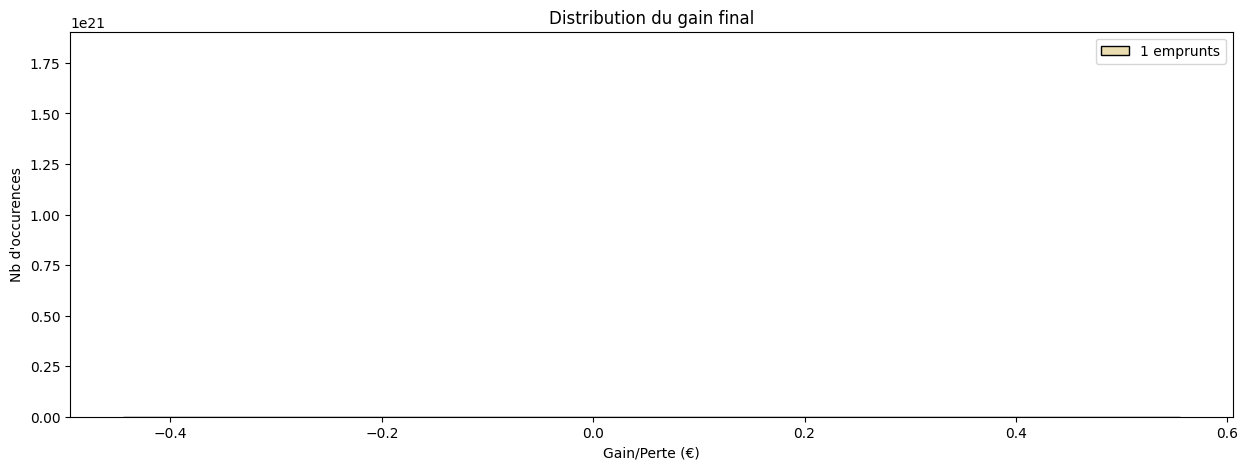

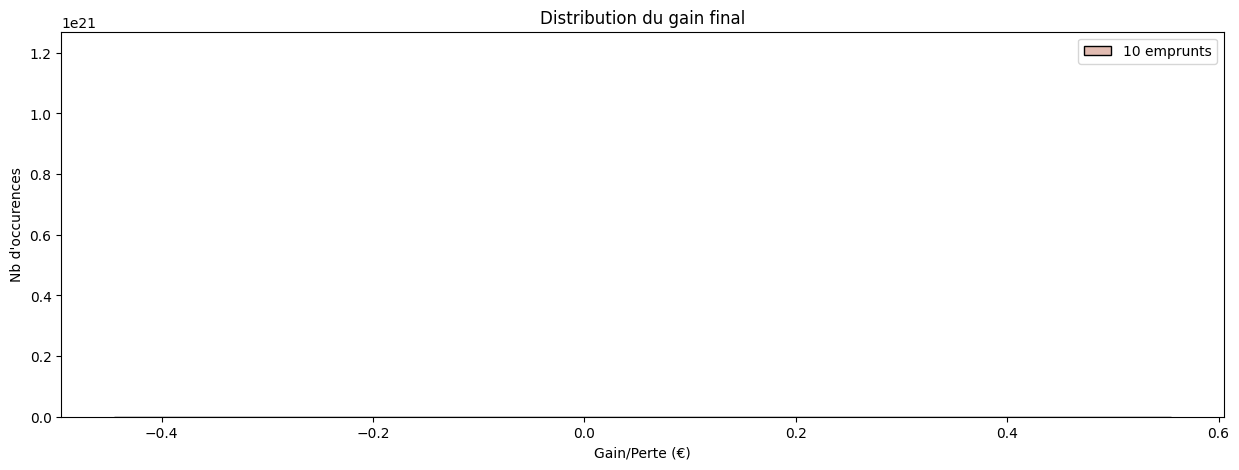

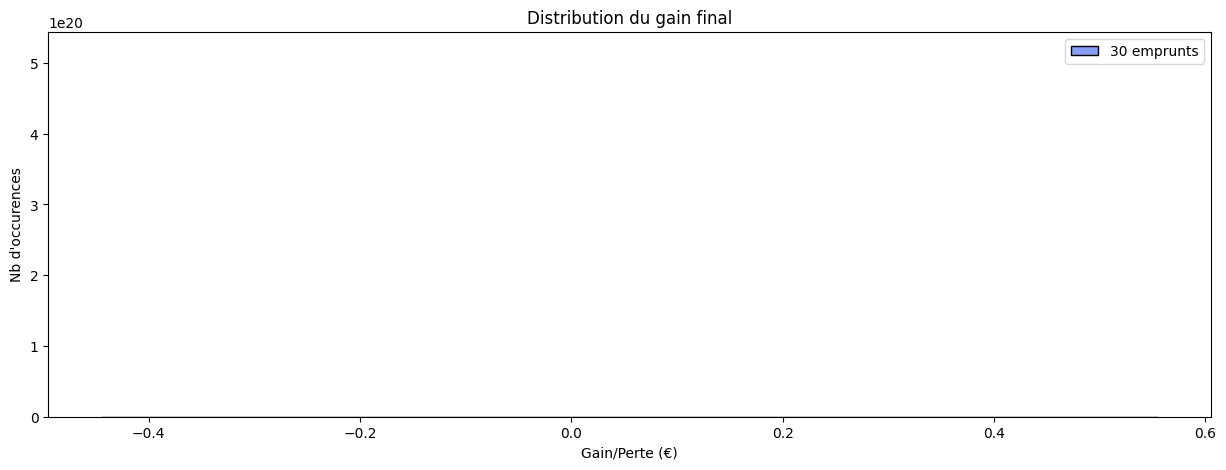

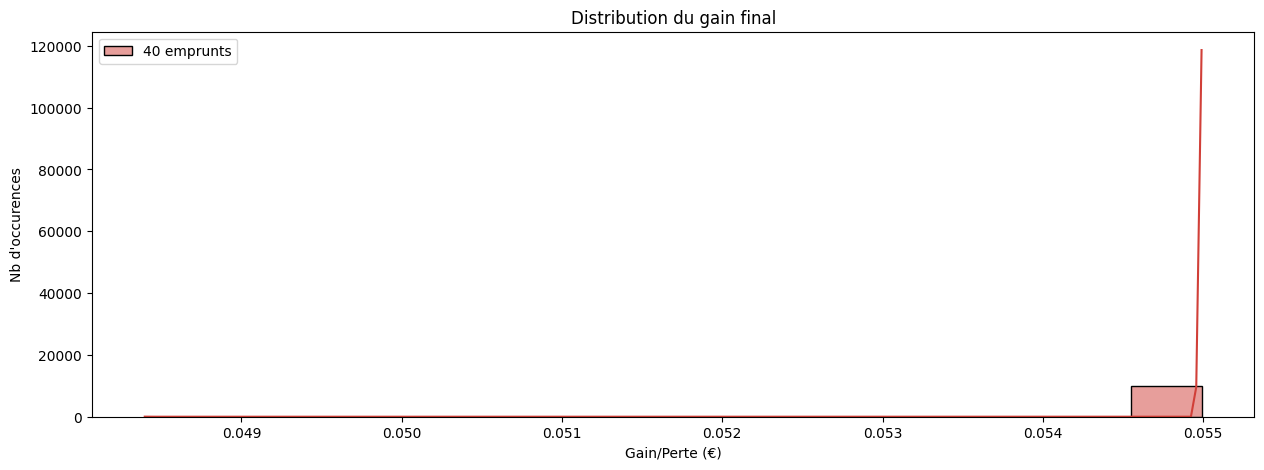

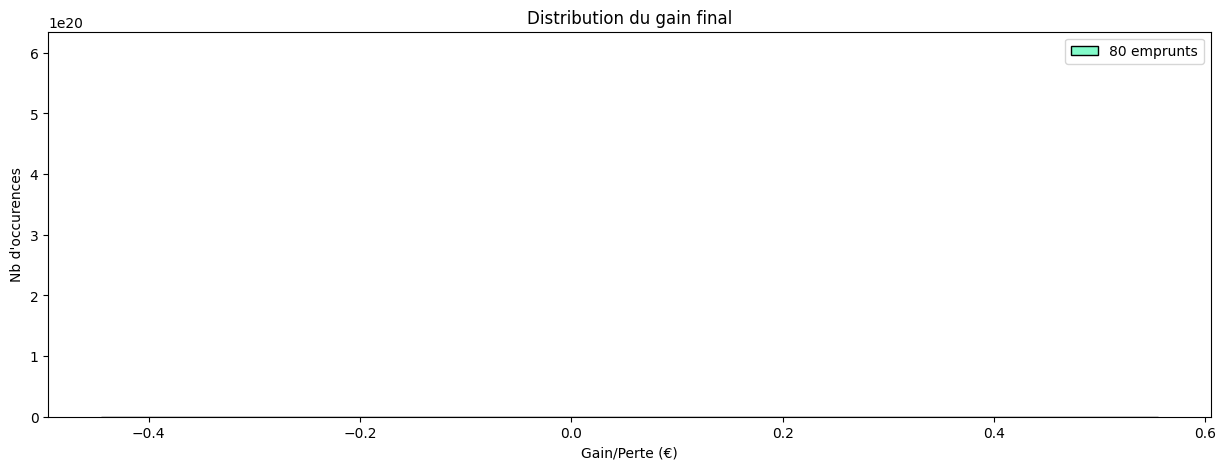

In [20]:
b.plot_results()

In [1]:
s = Strategy([10], 100, "2023-01-01", 0.01, 0.06)

e1 = Emprunteur_agent(0.01, 1000, 12, 0.06//12, "2023-01-01")
e2 = Emprunteur_agent(0.0975, 1000, 12, 0.06//12, "2023-01-01")

p = Portfolio([e1, e2], 0)
p.mensualite_totale()

p.amortissement_emprunteur(e1)
p.amortissement_emprunteur(e2)


NameError: name 'Strategy' is not defined

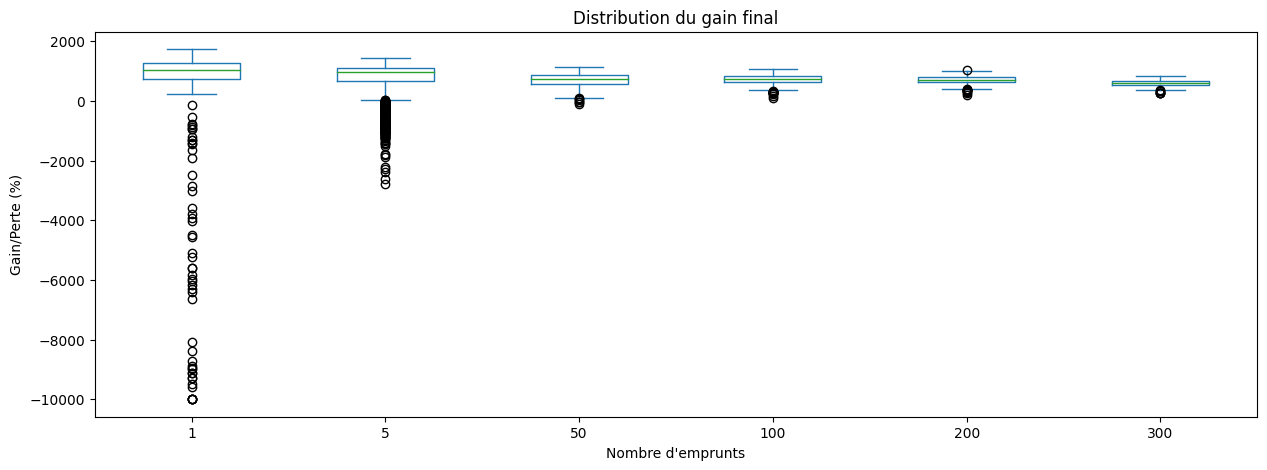

In [157]:
b.final_liquidite.plot(kind='box', figsize=(15, 5), title="Distribution du gain final")
plt.xlabel("Nombre d'emprunts")
plt.ylabel("Gain/Perte (%)")
plt.show()